### This is where the previous code and model training should go

Here I am just filling in with a random model (untrained)

In [ ]:
# download the dataset into a newly created folder called data
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_test_meta.csv
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_test_x.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_test_y.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_train_meta.csv
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_train_x.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_train_y.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_valid_meta.csv
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_valid_x.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_valid_y.h5

In [2]:
# these variables would have to be defined by you
data_prefix = 'data'

#!pip install h5py
import torch
import torchvision
import torch.nn as nn

# Load the data splits
# this dataset requires the h5py package
pcam_data_train = torchvision.datasets.PCAM(
    root=data_prefix,
    split='train',
    download=False,
    transform=torchvision.transforms.ToTensor() # otherwise the data is a PIL image
)
pcam_data_val = torchvision.datasets.PCAM(
    root=data_prefix,
    split='val',
    download=False,
    transform=torchvision.transforms.ToTensor()
)
pcam_data_test = torchvision.datasets.PCAM(
    root=data_prefix,
    split='test',
    download=False,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
import torch
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(96*96*3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax()
)

### Using RISE to see which pixels were important for making a prediction

The following code is taken and adapted from this repository: https://github.com/eclique/RISE/blob/master/Easy_start.ipynb

Once you have trained a model called `model`, you can use the following code to visualize part of the decision making.

In [ ]:
!pip install scikit-image
import numpy as np
import torch
import torch.nn as nn
import torchvision
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up the class RISE

class RISE(nn.Module):
    def __init__(self, model, input_size, gpu_batch=100):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch

    def generate_masks(self, N, s, p1, savepath='masks.npy'):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        np.save(savepath, self.masks)
        self.masks = torch.from_numpy(self.masks).float()
        self.masks = self.masks.cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def forward(self, x):
        N = self.N
        #_, _, H, W = x.size()
        _, H, W = x.size()
        # Apply array of filters to the image
        stack = torch.mul(self.masks, x.data)

        # p = nn.Softmax(dim=1)(model(stack)) processed in batches
        p = []
        for i in range(0, N, self.gpu_batch):
            p.append(self.model(stack[i:min(i + self.gpu_batch, N)]))
        p = torch.cat(p)#.unsqueeze(1)
        # Number of classes
        CL = p.size(1)
        sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(N, H * W))
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p1
        return sal

In [5]:
# define the image size
input_size = (96,96)
model.to(device)
# initialize the explainer model
explainer = RISE(model, input_size)
# Generate masks for RISE
maskspath = 'masks.npy'
explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)

Generating filters: 100%|██████████| 6000/6000 [00:03<00:00, 1679.67it/s]


In [6]:
# create a function to visualize example images
# and a heatmap showing the pixel importance of that image
def example(img, label):
    print(img.shape)
    #saliency = explainer(img.unsqueeze(0).to(device)).cpu().numpy()
    saliency = explainer(img.to(device)).cpu().numpy()
    p, c = torch.topk(model(img.unsqueeze(0).to(device)), k=1)

    plt.figure(figsize=(6, 3))
    print("Cancer: "+str(label))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(torchvision.transforms.ToPILImage()(img))

    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(torchvision.transforms.ToPILImage()(img))
    sal = saliency[c]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

torch.Size([3, 96, 96])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Cancer: 0


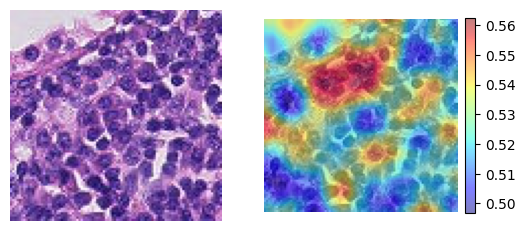

torch.Size([3, 96, 96])
Cancer: 1


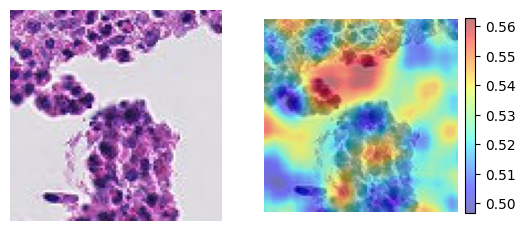

torch.Size([3, 96, 96])
Cancer: 1


KeyboardInterrupt: 

In [7]:
for i in range(10):
  example(pcam_data_train[i][0], pcam_data_train[i][1])